In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from tensorflow.keras.applications.resnet  import  ResNet50 as resNet
from tensorflow.keras.models import Sequential
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu

In [2]:
img_width,img_height = 1024,1024

root_path = "C:/Users/Admin/Videos/WheatSSGC/"
train_path = root_path+"/train"
test_path =  root_path+"/test"
train_csv_path =  root_path+"/train.csv"
sample_path =  root_path+"/sample_submission.csv"

In [3]:
total_df = pd.read_csv(train_csv_path)
total_ids =  [i.split(".")[0] for i in  os.listdir(train_path)]
total_df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [4]:
def draw_bboxes(bboxs,img):
    color = (255, 0, 0) 
    thickness = 3
    for cur_box  in bboxs:
        start_point = (cur_box[0],cur_box[1])
        end_point = (cur_box[2]+cur_box[0],cur_box[3]+cur_box[1])
   
        
        cv2.rectangle(img, start_point, end_point, color, thickness) 

    return img

In [5]:
def get_bboxes(image_id):
    selected_df = total_df[total_df['image_id'] == image_id]
    
    image_bboxes = selected_df['bbox']
    box_scores = selected_df['bbox']
    bboxes = []
    for row in image_bboxes:
        row=row.replace(" ", "")
        x1y1x2y2 = np.array(re.findall("([0-9]+[.]?[0-9]*)", row))
        x1y1x2y2 = np.float32(x1y1x2y2)
        x1y1x2y2 = x1y1x2y2
        x1y1x2y2 =  np.int32(x1y1x2y2)
  
        bboxes.append(x1y1x2y2)
           
        
    return bboxes

In [6]:
def read_image(image_id):
    path = train_path+'/'+str(image_id)+'.jpg'
    image = Image.open(path)
    image = image.resize((img_width,img_height))
    
    return np.asarray(image)
    

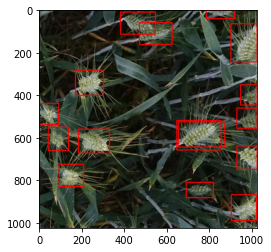

In [7]:
N = 10
image_id = total_ids[N]
selected_df = total_df.loc[total_df['image_id'] == image_id]
bboxes = get_bboxes(image_id)
sample_img  = read_image(image_id)
box_img =  draw_bboxes(bboxes,sample_img)
plt.imshow(box_img)

Text(0.5, 0.98, 'Same Examples Images')

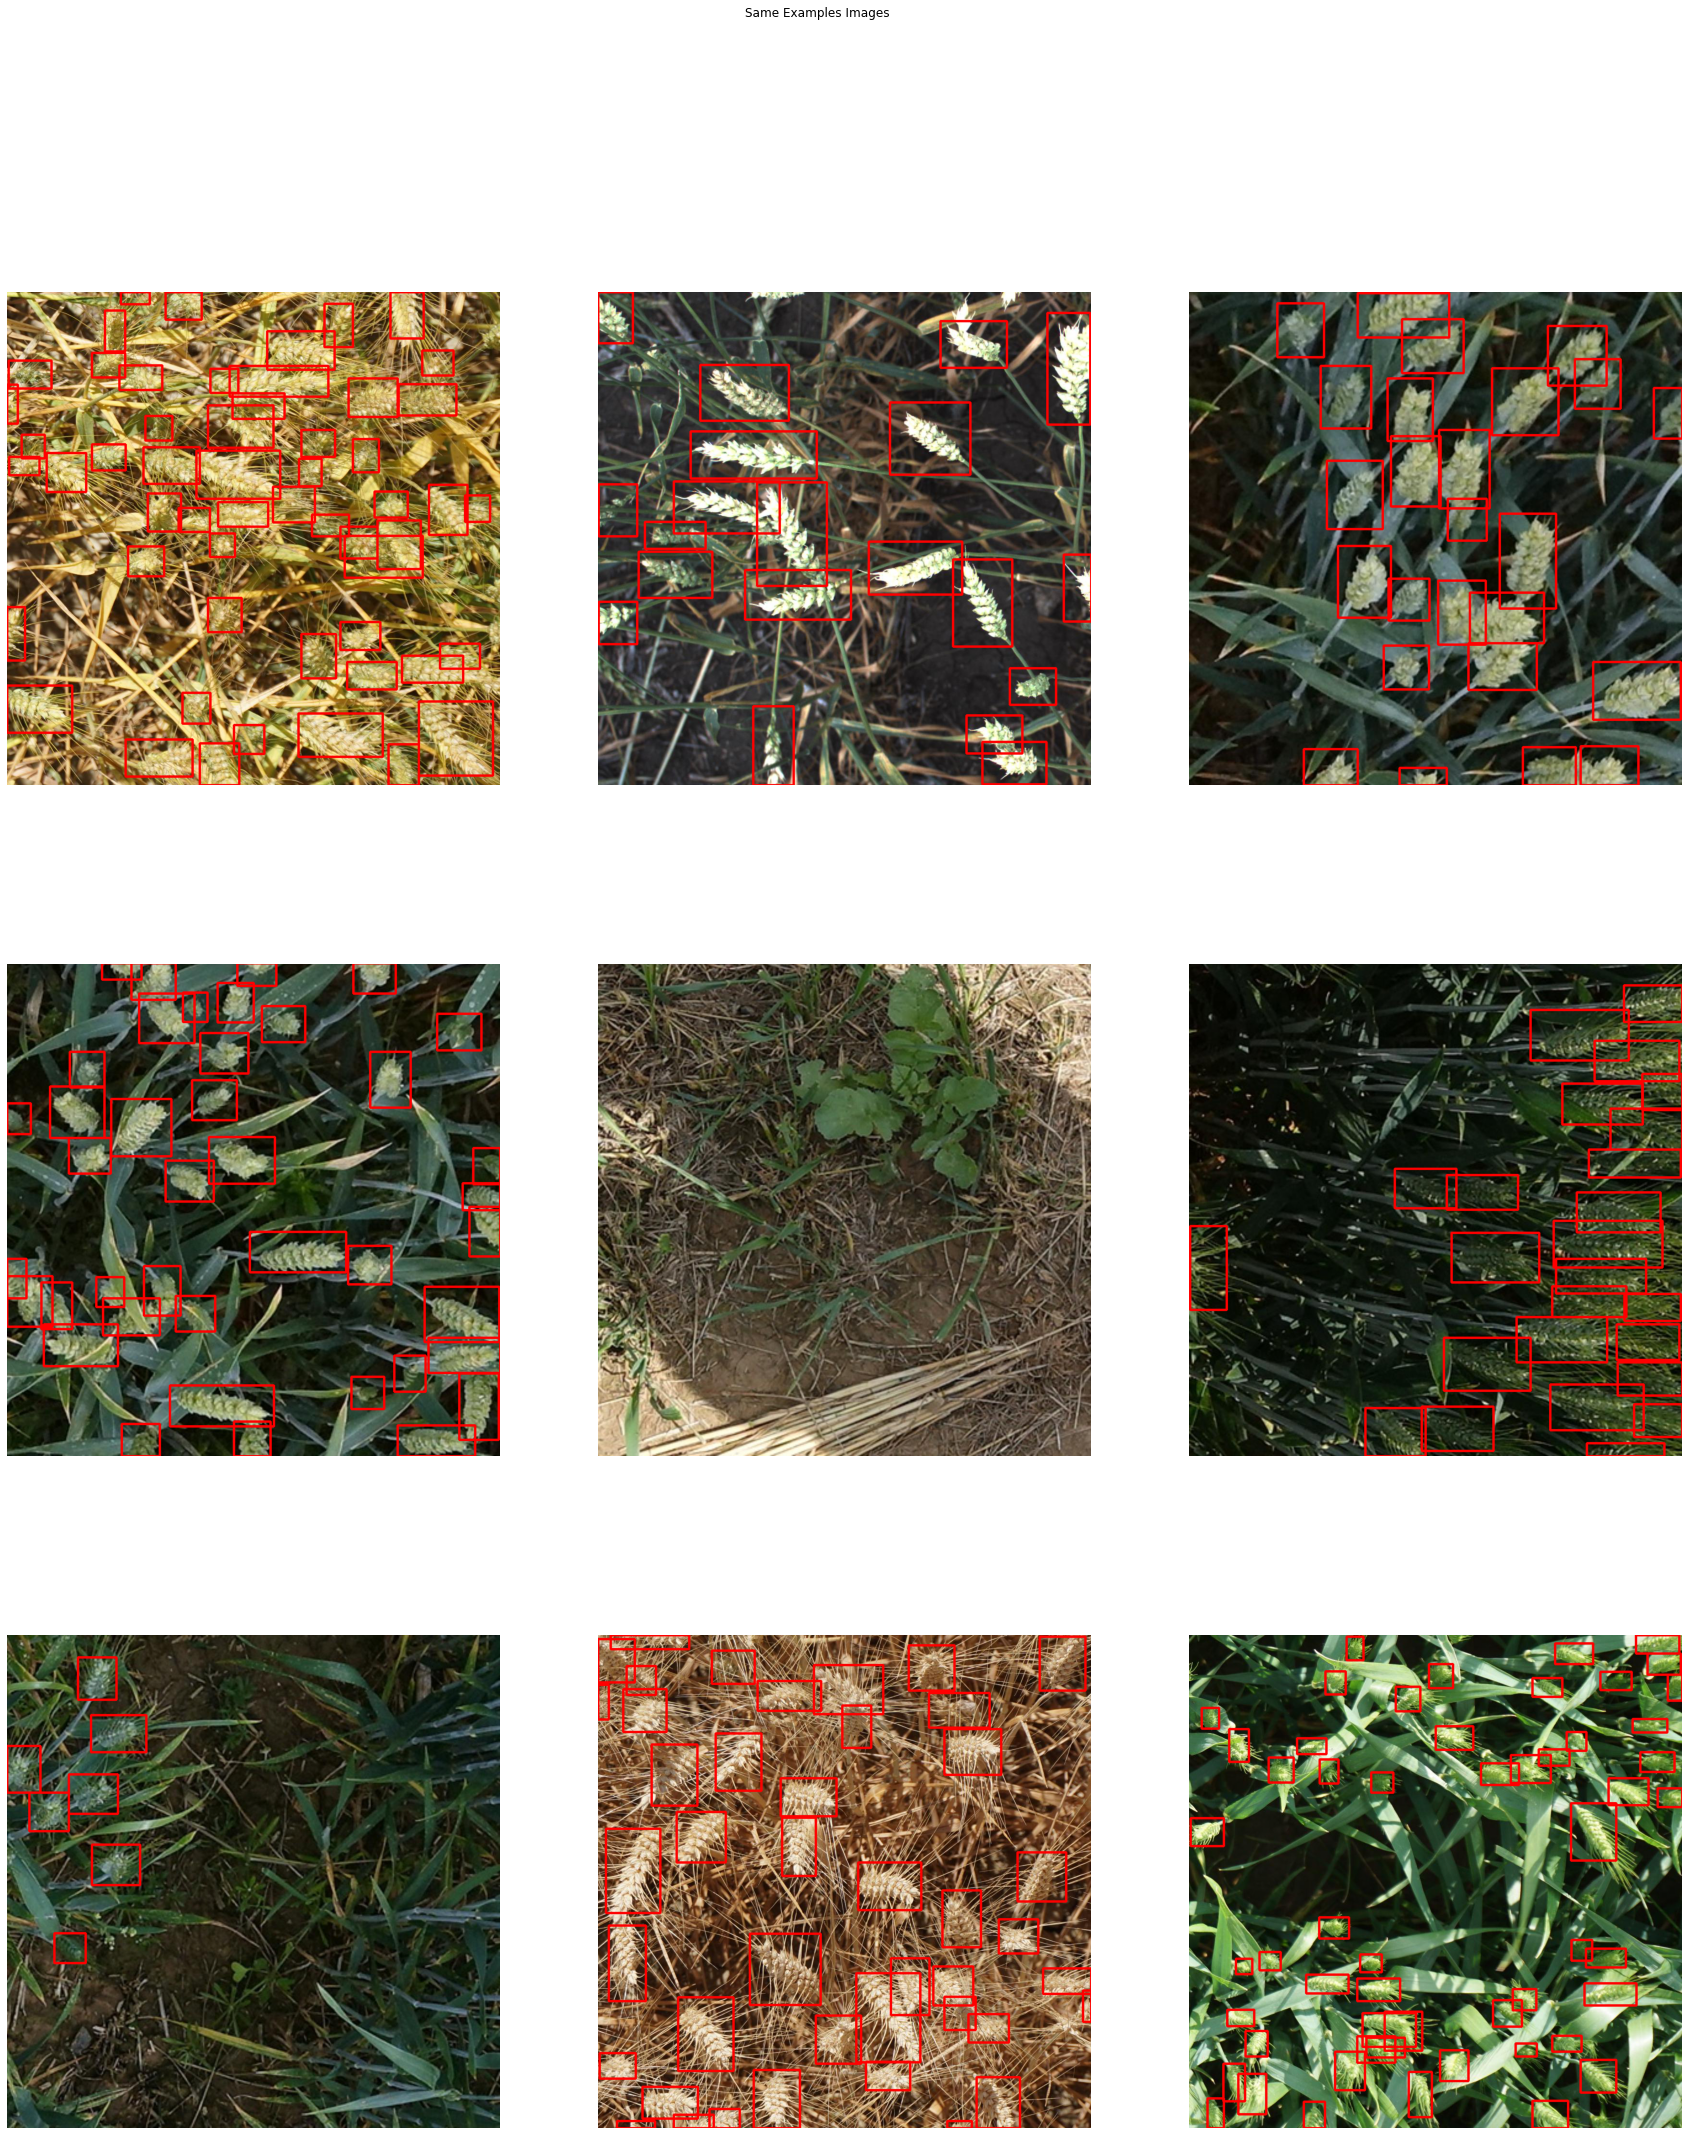

In [8]:
rows=3
cols=3
N = 0
fig, axs = plt.subplots(rows, cols, figsize=(30,35))
for row in range(rows):
    for col in range(cols):
        image_id = total_ids[N]
        selected_df = total_df.loc[total_df['image_id'] == image_id]
        read_path = train_path+"\\"+image_id+".jpg"
        sample_img = read_image(image_id)
        


        if selected_df.empty:
            axs[row, col].imshow(sample_img)
            axs[row, col].axis('off')
            
            N = N+1
            continue
    
        
        bboxes = get_bboxes(image_id)
        box_img =  draw_bboxes(bboxes,sample_img)
        axs[row, col].imshow(box_img)
        axs[row, col].axis('off')
        N = N+1

plt.suptitle("Same Examples Images")

In [9]:
total_amount = len(os.listdir(train_path))
split_rate = 0.98
train_amount = int(total_amount * split_rate)
test_amount = total_amount - train_amount
print("Train amount : ",train_amount)
print("Test amount : ",test_amount)

Train amount :  3353
Test amount :  69


In [10]:
train_ids = total_ids[:train_amount]
val_ids = total_ids[train_amount:]

In [11]:
train_images = {}
train_labels = {}
for image_id in train_ids:
    bboxes = get_bboxes(image_id)
    train_labels[image_id] = bboxes
    train_images[image_id] = read_image(image_id)

In [12]:
val_images = {}
val_labels = {}
for image_id in val_ids:
    bboxes = get_bboxes(image_id)
    val_labels[image_id] = bboxes
    val_images[image_id] = read_image(image_id)

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.from_image_grid()
        
    def from_image_grid(self):
        image_grid = np.zeros((32,32,4))
        
        # x, y, width, height
        cell = [0, 0, 256/32, 256/32]
        
        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i,j] = cell
                
                cell[0] = cell[0] + cell[2]
                
                
            cell[0] = 0
            cell[1] = cell[1] + cell[3]
            
        return image_grid

In [14]:
DataGenerator.train_augmentations = albu.Compose([
    albu.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=img_height, 
            width=img_width, 
            p=0.8
        ),
    albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
    albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
    albu.OneOf([
            albu.GaussNoise(),
            albu.GlassBlur(),
            albu.ISONoise(),
            albu.MultiplicativeNoise(),
        ], p=0.5),
    albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            fill_value=0, 
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

In [15]:
def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))

def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))
    
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

DataGenerator.__len__ = __len__ 
DataGenerator.on_epoch_end = on_epoch_end

In [16]:
def __getitem__(self, index):
    indexes =  self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

  
    return X,y

In [17]:
def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)

In [18]:
def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)
    bboxes = self.form_label_grid(aug_result['bboxes'])
    

    
    return np.array(aug_result['image']) / 255, bboxes

def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

In [19]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid

In [20]:
def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            elif anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break


    return np.concatenate((anchor_one, anchor_two), axis=None)

In [21]:
def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / img_width
    box_height = box_height / img_height
    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [22]:
train_generator = DataGenerator(
    train_ids,
    train_images,
    train_labels, 
    batch_size=4, 
    shuffle=True,
    augment=True
)


val_generator = DataGenerator(
    val_ids, 
    val_images,
    val_labels, 
    batch_size=4,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid
image_grid.shape

(32, 32, 4)

In [23]:
print(np.array(train_labels[train_ids[0]]).shape)
print(np.array(train_images[train_ids[0]]).shape)
print(train_ids[0])

(55, 4)
(1024, 1024, 3)
00333207f


In [24]:
x,y = train_generator.__getitem__(0)

print(x.shape)
print(y.shape)

(4, 1024, 1024, 3)
(4, 32, 32, 10)


In [25]:
img_input_shape = (img_width,img_height,3)
base_model =resNet(include_top=False, weights='imagenet', input_shape=img_input_shape)
base_model.summary()

94781440/94765736 [==============================] - 18s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 1030, 1030,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 512, 512, 64  9472        ['conv1_pad[0][0]']              
                         

In [26]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss

In [29]:
def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [31]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

base_model.compile(
    optimizer=optimiser, 
    loss=custom_loss,
    metrics = ['accuracy']
)

In [33]:
history = base_model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    steps_per_epoch = 8,
    
)

C:\Users\Admin\AppData\Local\Temp/ipykernel_8464/2213744415.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(


8/8 [==============================] - 283s 36s/step - loss: 3.0614 - accuracy: 3.0518e-05 - val_loss: 10.1720 - val_accuracy: 0.0000e+00


In [35]:
base_model.save("test_model.h5")

C:\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [37]:
#base_model = tf.keras.models.load_model("test_model.h5")

In [38]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 32)
    im_height = (image_grid[:,:,3] * 32)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

In [44]:
def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        print(predictions[i])

        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        print(predictions[i])
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

In [45]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    bboxes = switch_x_y(bboxes)
   
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    bboxes = switch_x_y(bboxes)
    
    return bboxes


def switch_x_y(bboxes):
    x1 = bboxes[:,0].copy()
    y1 = bboxes[:,1].copy()
    x2 = bboxes[:,2].copy()
    y2 = bboxes[:,3].copy()
    
    bboxes[:,0] = y1
    bboxes[:,1] = x1
    bboxes[:,2] = y2
    bboxes[:,3] = x2
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    print(top_indices.shape)
    return boxes[top_indices], probabilities[top_indices]

In [46]:
model_predictions = base_model.predict(val_generator)
print("Model output : ",model_predictions.shape)

Model output :  (68, 32, 32, 2048)


In [48]:
val_predictions = model_predictions, val_ids, image_grid
print(val_predictions)
model_predictions[0].shape

(array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.04178262e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  8.00000000e+00,  0.00000000e+00, ...,
           2.41014862e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.60000000e+01,  0.00000000e+00, ...,
           1.54023647e-01,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  2.32000000e+02,  0.00000000e+00, ...,
           3.47654223e-01,  8.65422130e-01,  0.00000000e+00],
         [ 0.00000000e+00,  2.40000000e+02,  0.00000000e+00, ...,
           2.12271988e-01,  1.06981707e+00,  0.00000000e+00],
         [ 2.89902687e-02,  2.48000000e+02,  0.00000000e+00, ...,
           2.89646101e+00,  3.73837471e-01,  0.00000000e+00]],

        [[ 1.33455634e+00,  0.00000000e+00,  1.36185684e+01, ...,
           2.39570379e-01,  0.00000000e+00,  0.00000000e+00],
         [ 1.79525518e+00,  8.00000000e+00,  8.00000000e+00, ...,
           5.04266357

(32, 32, 2048)

In [59]:
 
rows=5
cols=5
N = 0
#fig, axs = plt.subplots(rows, cols, figsize=(30,35))
for row in range(rows):
    for col in range(cols):
        image_id = val_ids[N]
        print(image_id)
        sample_img = read_image(image_id)
  


        if selected_df.empty:
            axs[row, col].imshow(sample_img)
            axs[row, col].axis('off')
            
            N = N+1
            continue
    
        
        #bboxes = val_predictions[image_id]
        bboxes = np.square(bboxes)/255
        print(bboxes)
      #  box_img =  draw_bboxes(bboxes*4,sample_img)
       # axs[row, col].imshow(box_img)
       # axs[row, col].axis('off')
       # N = N+1

#plt.suptitle("Same Val Examples Images")

fae71c97b
[[inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]]
fae71c97b
[[inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf 

[[inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]]
fae71c97b
[[inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 

[[inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf  0.  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [inf inf  0.  0.]
 [ 0. inf  0.  0.]
 [ 0. inf  0.  0.]]


In [63]:
sample_df = pd.read_csv(sample_path)
sample_df.head()

image_id PredictionString
0  aac893a91    1.0 0 0 50 50
1  51f1be19e    1.0 0 0 50 50
2  f5a1f0358    1.0 0 0 50 50
3  796707dd7    1.0 0 0 50 50
4  51b3e36ab    1.0 0 0 50 50